# Convergence test of CTHYB solver parameters

## Overview

The goal is to find out how to initialize the CTHYB solver to obtain better results. The solver parameters can be investigated according to their role in increasing efficiency or accuracy.

#### efficiency                                       
1. length_cycle                   
2. n_warmup_cycles            

#### accuracy
3. n_cycles
4. n_iw 
5. n_l 
6. n_tau

In [1]:
import numpy as np
from math import pi
from triqs.gf import *
from triqs.plot.mpl_interface import oplot,plt
from matplotlib import pyplot
from triqs.gf import make_gf_from_fourier
from triqs.operators import *
from h5 import *
from h5 import HDFArchive
from triqs_cthyb import Solver
import scipy.optimize as opt
import os
import math

# Make plots show up directly in the notebook:
%matplotlib inline

# Make all figures slightly bigger
import matplotlib as mpl
from matplotlib.markers import MarkerStyle
mpl.rcParams['figure.dpi']=100

Starting serial run at: 2022-08-02 15:43:33.324309


## Efficiency

### 1. length_cycle
Number of moves (updates/steps, they all refer to the same concept!) between each measurment. In CTHYB the measured observable is the Green's function in imaginary time, $G(\tau)$. Each "move" modifies the configuration of the system (state of the system, which here is $\mathcal{C}=d^{\dagger}_{\alpha_{1}}(\tau_1) d_{\alpha^{'}_{1}}(\tau^{'}_1) d^{\dagger}_{\alpha_{2}}(\tau_2) . . . d_{\alpha}(\tau_N)$) by inserting/removing pairs of operators, or by moving operators in the configuration. So let's say each measurment is done every **L** moves, then we say that these **L** moves form a cycle and the length of the cycle is **L**.

The reason we don't do measurments after each move is beacuse we want the configurations to be decorrelated from each other. To get an idea of decorrelation, there are two observables we can look at: average_sign and average_order, which vary from one configuration to another. Plotting the standard deviation of average_sign/order versus number of moves, shows that it converges to a value called **auto-correlation time**. Auto-correlation time * length_cycle is equal to the number of moves one needs between two measurments for them to be decorrelated. Therefore if auto-correlation time=1, it means the length_cycle value chosen for the calculation is optimized. Larger auto-correlation time means your calculation will take longer and thus is less efficient.

Here we take a single orbital Hubbard model at half-filling for three different betas $\mathcal{\beta} = 10, 20, 30$ and plot auto_correlation time vs length_cycle. The fit approximately shows what the converged value of length_cycle is for each beta..

In [ ]:
t = 1.0
betas = [10, 20, 30]
n_loops = 1
U = 2.0
mu = 0.0
length_cycle = np.arange(20,520,20)

for b in range(len(betas)):
    if not os.path.exists('../../../triqs/data/len_cyc_b%i'%betas[b]):
        os.makedirs('../../../triqs/data/len_cyc_b%i'%betas[b])

    for j in range(len(length_cycle)):
        S = Solver(beta = betas[b], gf_struct = [('up',1), ('down',1)])
        S.G_iw << SemiCircular(2*t)
        # DMFT loop with self-consistency
        for i in range(n_loops):
            print("\n\nIteration = %i / %i" % (i+1, n_loops))
            # Symmetrize the Green's function and use self-consistency
            g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
            for name, g0 in S.G0_iw:
                g0 << inverse( iOmega_n + U/2.0 - mu - t**2 * g )

                # Solve the impurity problem
            S.solve(h_int = U * n('up',0) * n('down',0),   # Local Hamiltonian 
                n_cycles  = 10000,                           # Number of QMC cycles
                length_cycle = length_cycle[j],
                n_warmup_cycles = 3000,                      # Warmup cycles
                )
            # Save iteration in archive
            with HDFArchive('../../../triqs/data/len_cyc_b%i/half-U-lc%i.h5'%(betas[b], length_cycle[j])) as A:
                A['a%i'%i] = S.auto_corr_time
                A['b%i'%i] = S.average_order

Text(-1, -1.5, '$auto correlation = 1$')

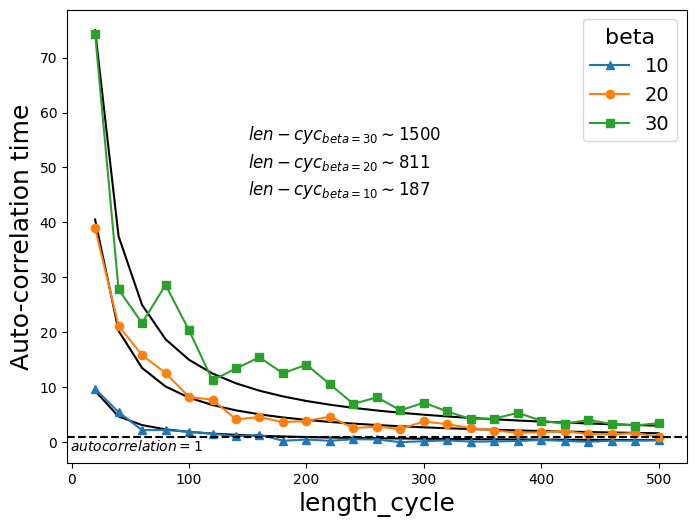

In [3]:
def func(x, a):
     return a* 1/(x)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
length_cycle = np.arange(20,520,20)
betas = [10, 20, 30]
marker=['-^', '-o', '-s']
for b in range(len(betas)):
    d = []
    for j in range(len(length_cycle)):
        R = HDFArchive('../../../triqs/data/len_cyc_b%i/half-U-lc%i.h5'%(betas[b], length_cycle[j]), 'r')
        d.append(R['a0'])
    optimizedParameters, pcov = opt.curve_fit(func, length_cycle, d);
    ax.plot(length_cycle, func(length_cycle, *optimizedParameters), color='k');
    ax.plot(length_cycle, d, marker[b], label='%i'%betas[b])
    ax.text(150, 40+betas[b]/2, r'$len-cyc_{beta=%i}\sim %i$'%(betas[b], math.ceil(optimizedParameters)), fontsize=12)
ax.set_ylabel('Auto-correlation time',fontsize=18)
ax.set_xlabel('length_cycle',fontsize=18)
plt.legend(title="beta", title_fontsize=16, fontsize=14)
ax.axhline(y=1, linestyle='--', color='k')
# ax.set_xlim(-15,520)
# ax.text(35, 50, r'$y\sim\frac{1500}{x}$', fontsize=12)
# ax.text(-8, 19, r'$y\sim\frac{810}{x}$', fontsize=12)
# ax.text(-3, 10, r'$y\sim\frac{186}{x}$', fontsize=12)
ax.text(-1, -1.5, '$auto correlation = 1$', fontsize = 10)

### 2. n_warmup_cycles
The systme needs to be thermalized first, i.e. for the first few thousand cycles (n_warmup_cycles) we don't do measurments. In order to have an estimate of how many cycles are needed for thermalization, we set n_warmup_cycle to be zero in the solver and plot the average_order vs the number of cycles. This way measurments are done from the beginning and the number of cycles at which the average_order starts to saturate is a good estimate for n_warmup_cycles.

In [ ]:
t = 1.0
betas = [10, 50, 100]
n_loops = 1
U = 2.0
mu = 0.0
n_cycles = np.arange(100,8000,100)

for b in range(len(betas)):
    if not os.path.exists('../../../triqs/data/warm_up_b%i'%betas[b]):
        os.makedirs('../../../triqs/data/warm_up_b%i'%betas[b])

    for j in range(len(n_cycles)):
        S = Solver(beta = betas[b], gf_struct = [('up',1), ('down',1)])
        S.G_iw << SemiCircular(2*t)
        # DMFT loop with self-consistency
        for i in range(n_loops):
            print("\n\nIteration = %i / %i" % (i+1, n_loops))
            # Symmetrize the Green's function and use self-consistency
            g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
            for name, g0 in S.G0_iw:
                g0 << inverse( iOmega_n + U/2.0 - mu - t**2 * g )

                # Solve the impurity problem
            S.solve(h_int = U * n('up',0) * n('down',0),   # Local Hamiltonian 
                n_cycles  = n_cycles[j],                           # Number of QMC cycles
                length_cycle = 200,
                n_warmup_cycles = 0,                      # Warmup cycles
                )
            # Save iteration in archive
            with HDFArchive('../../../triqs/data/warm_up_b%i/half-U-wu%i.h5'%(betas[b], n_cycles[j])) as A:
                A['a%i'%i] = S.auto_corr_time
                A['b%i'%i] = S.average_order

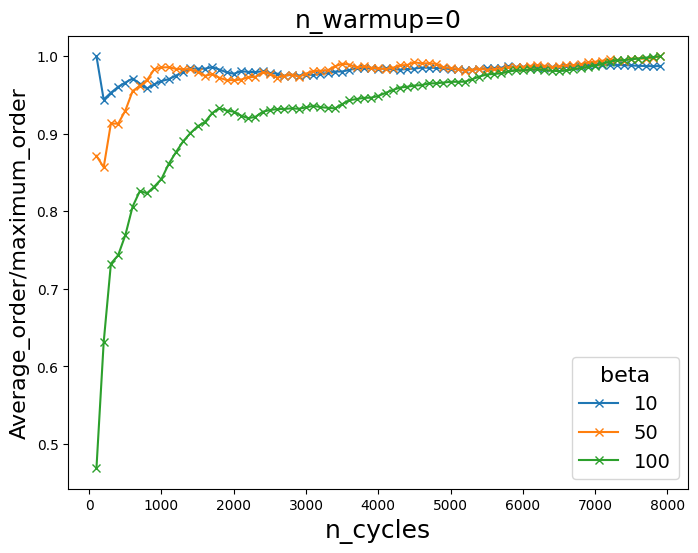

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
n_cycles = np.arange(100,8000,100)
betas = [10, 50, 100]
for b in range(len(betas)):
    d = []
    for j in range(len(n_cycles)):
        R = HDFArchive('../../../triqs/data/warm_up_b%i/half-U-wu%i.h5'%(betas[b], n_cycles[j]), 'r')
        d.append(R['b0'])
    d=list(map(lambda x: x/max(d), d))
    ax.plot(n_cycles, d, '-x', label='%i'%betas[b])

ax.set_ylabel('Average_order/maximum_order', fontsize=16)
ax.set_xlabel('n_cycles', fontsize=18)
ax.set_title('n_warmup=0', fontsize=18)
plt.legend(title="beta", title_fontsize=16, fontsize=14)

## Accuracy

### 3. n_cycles
The total number of measurments. Converged values of length_cycle and n_warmup_cycles are used from previous tests. The Green's function in imagniary time, $G(\tau$), obtained from the slover for different number of n_cycles is plotted. As you can see, larger n_cycles gives a smoother (less noisy) $G(\tau$).

In [ ]:
if not os.path.exists('../../../triqs/data/n_cycles_b10'):
    os.makedirs('../../../triqs/data/n_cycles_b10')
t = 1.0
beta = 10
n_loops = 1
U = 2.0
n_cycles = [32000, 64000, 128000, 256000, 512000, 1024000, 2048000]

for j in range(len(n_cycles)):
    print('n_cycles =', n_cycles[j])
    S = Solver(beta = beta, gf_struct = [('up',1), ('down',1)])
    S.G_iw << SemiCircular(2*t)

    for i in range(n_loops):
    
        print("\n\nIteration = %i / %i" % (i+1, n_loops))
        # Symmetrize the Green's function and use self-consistency
        g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
        for name, g0 in S.G0_iw:
            g0 << inverse( iOmega_n + U/2.0 - t**2 * g )

        # Solve the impurity problem
        S.solve(h_int = U * n('up',0) * n('down',0),   # Local Hamiltonian 
            n_cycles  = n_cycles[j],                           # Number of QMC cycles
            length_cycle = 187,
            n_warmup_cycles = 2000,                      # Warmup cycles
            )
    
        # Save iteration in archive
        with HDFArchive('../../../triqs/data/n_cycles_b10/half-U-nc%ik.h5'%(n_cycles[j]/1000)) as A:
            A['Gtau-%i'%i] = S.G_tau
            # A['G-%i'%i] = S.G_iw

Text(0.02, 0.5, '$G(\\tau)$')

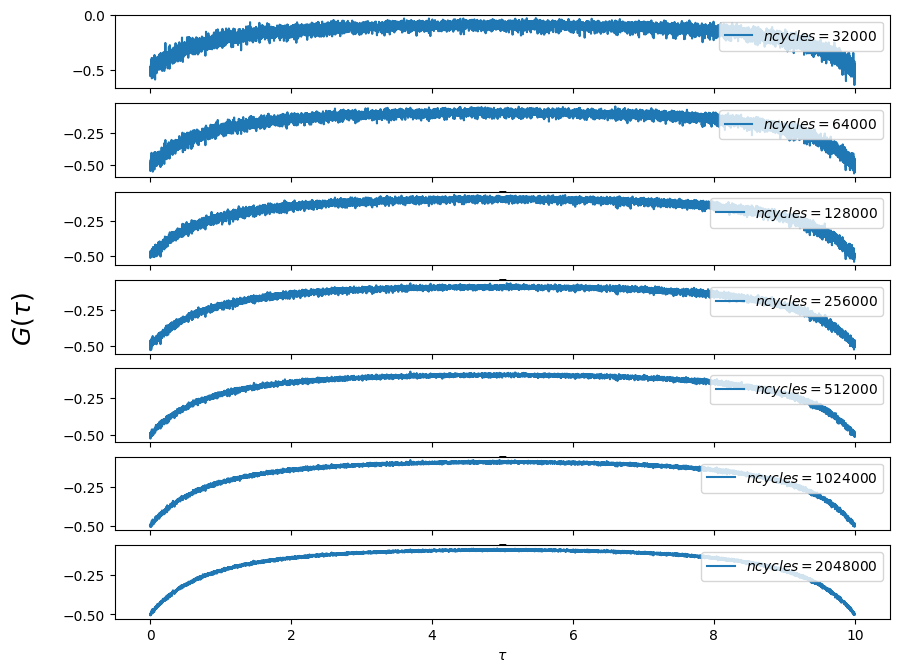

In [2]:
fig, ax = plt.subplots(7, 1, figsize=(10, 8), sharex=True)
n_cycles = [32000, 64000, 128000, 256000, 512000, 1024000, 2048000]
for j in range(len(n_cycles)):
    A1 = HDFArchive('../../../triqs/data/n_cycles_b10/half-U-nc%ik.h5'%(n_cycles[j]/1000), 'r')
    ax[j].oplot(A1['Gtau-0']['up'].real, '-', label=r"$ncycles = %i$"%n_cycles[j])
    ax[j].set_ylabel('')

fig.supylabel(r'$G(\tau)$', fontsize="18")

### 4. n_iw

The number of Matsubara frequencies used for the Green’s functions. We plot the density of the Green's function for different sizes of the frequency mesh. 

$n=\langle c^\dagger c\rangle$\
$G(\tau)=-\langle T c(\tau)c^\dagger\rangle=\langle T c^\dagger c(\tau)\rangle \rightarrow G(\tau=0^-)=\langle c^\dagger c\rangle=n$\
$G(\tau=0^-)=\sum_{i\omega_n}{e^{i\omega_n0^-}G(i\omega_n)}=\sum_{i\omega_n}{G(i\omega_n)}$\
$\Rightarrow $ $n=\sum_{i\omega_n}{G(i\omega_n)}$\

Therefore density (n) is a good criterion for determining the size of the Matsubara frequency mesh.

 Error = 0.000665894
 Please make sure you treat the constant offset analytically!
/cm/shared/sw/nix/store/h67ird3i9fcnd25n8j7y61n75ifp8vsq-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
 Error = 0.00528623
 Please make sure you treat the constant offset analytically!


Text(0.5, 0, '$i\\omega_{max}$')

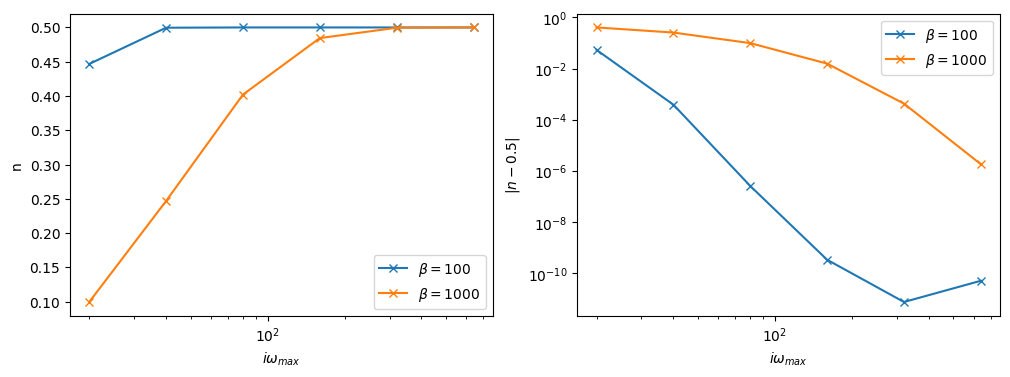

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
D = 1.5  # Half bandwidth
beta = [100, 1000]
n_max = [20, 40, 80, 160, 320, 640]
for i in range(len(beta)):
    d = []
    for j in range(len(n_max)):
        iw_mesh = MeshImFreq(beta=beta[i], S='Fermion', n_max=n_max[j])
        G = Gf(mesh=iw_mesh, target_shape=[])
        G << SemiCircular(D)
        d.append(G.density())
    ax[0].set_xscale("log")
    ax[0].plot(n_max, d, '-x', label=r"$\beta = %i$"%beta[i])
    d = list(map(lambda x: x - 0.5, d))
    d = list(map(abs, d))
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[1].plot(n_max, d, '-x', label=r"$\beta = %i$"%beta[i])

ax[0].legend(loc="best")
ax[0].set_xlabel('$i\omega_{max}$')
ax[0].set_ylabel('n')
ax[1].set_ylabel('$|n-0.5|$')
ax[1].legend()
ax[1].set_xlabel('$i\omega_{max}$')

In the case of an interacting Green's function, it's better to look at the tails of the Green's function and see how close they are to zero for each frquency mesh, instead of density.

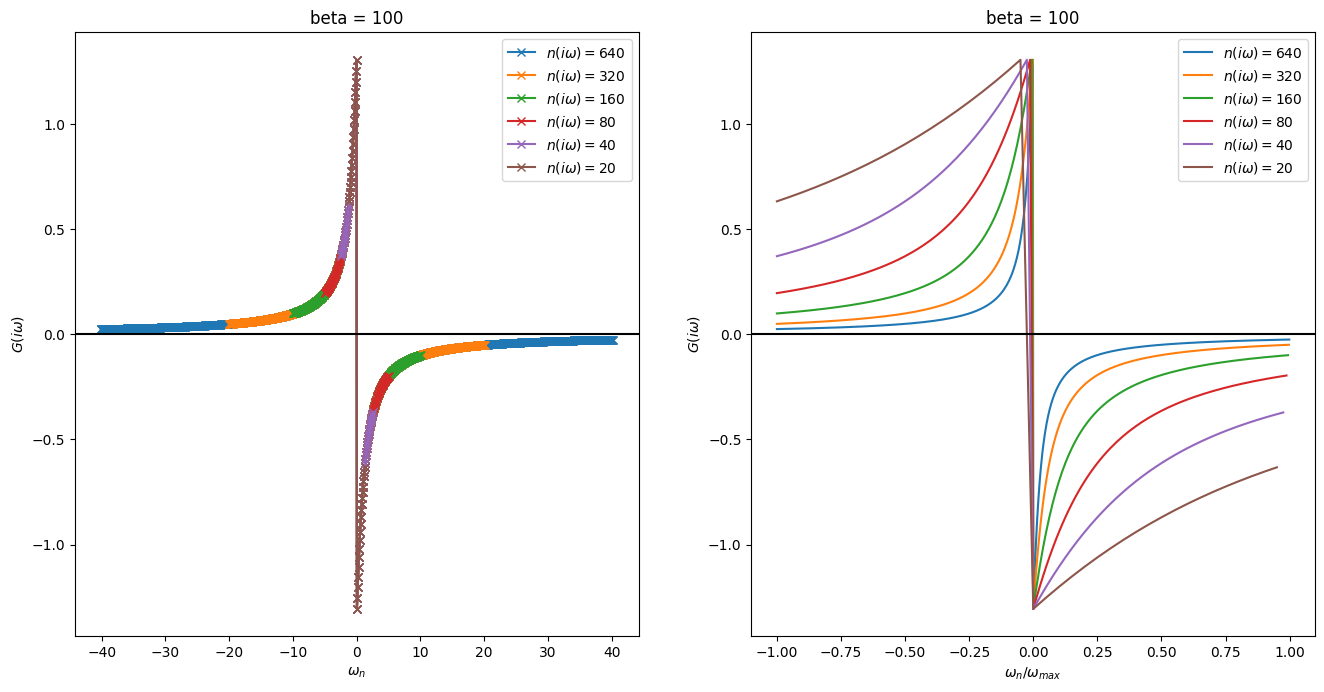

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
D = 1.5  # Half bandwidth
beta = 100
n_max = [640, 320, 160, 80, 40, 20]
for j in range(len(n_max)):
    a = np.arange(-n_max[j],n_max[j])
    iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_max=n_max[j])
    G = Gf(mesh=iw_mesh, target_shape=[1,1])
    G << SemiCircular(D)
    ax[0].oplot(G.imag, '-x', label=r"$n(i\omega)= %i$"%n_max[j])
    ax[1].plot(a/n_max[j], G.imag.data[:,0], label=r"$n(i\omega)= %i$"%n_max[j])
ax[0].set_ylabel("$G(i\omega)$")
ax[0].set_title("beta = %i"%beta)
ax[0].axhline(color='k')

plt.legend()
ax[1].set_ylabel("$G(i\omega)$")
ax[1].set_xlabel("$\omega_n/\omega_{max}$")
ax[1].set_title("beta = %i"%beta)
ax[1].axhline(color='k')

 Error = 0.000374834
 Please make sure you treat the constant offset analytically!
 Error = 0.00162047
 Please make sure you treat the constant offset analytically!
 Error = 0.00334563
 Please make sure you treat the constant offset analytically!
 Error = 0.00470173
 Please make sure you treat the constant offset analytically!
 Error = 0.00552797
 Please make sure you treat the constant offset analytically!


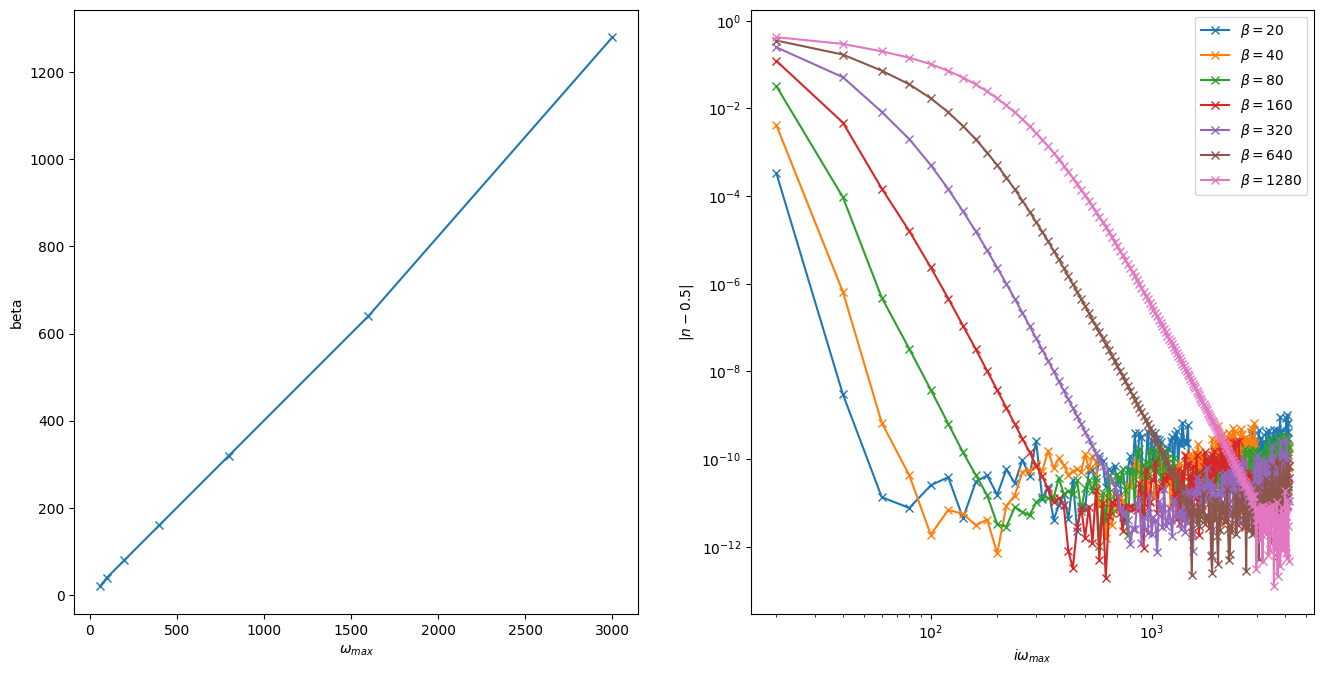

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
D = 1.5  # Half bandwidth
beta = [20, 40, 80, 160, 320, 640, 1280]
# n_max = [20, 40, 80, 160, 320, 640]
n_max = np.arange(20, 4200, 20)
for i in range(len(beta)):
    d = []
    for j in range(len(n_max)):
        iw_mesh = MeshImFreq(beta=beta[i], S='Fermion', n_max=n_max[j])
        G = Gf(mesh=iw_mesh, target_shape=[])
        G << SemiCircular(D)
        d.append(G.density())
    d = list(map(lambda x: x - 0.5, d))
    d = list(map(abs, d))
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[1].plot(n_max, d, '-x', label=r"$\beta = %i$"%beta[i])
omega = [60, 100, 200, 400, 800, 1600, 3000]
ax[0].plot(omega, beta, '-x')
ax[0].set_xlabel('$\omega_{max}$')
ax[0].set_ylabel('beta')
ax[1].set_ylabel('$|n-0.5|$')
ax[1].set_xlabel('$i\omega_{max}$')
plt.legend()

### 5. n_l

The number of legendre polynomials to use in accumulations of the Green’s function. We first need to define a function that transforms the Green's function from imaginary time to legendre.

$G(\mathcal{l})=\sqrt{2l+1}\int_0^{\beta}{d\tau}P_l[x(\tau)]G(\tau)$    

where $x(\tau)=2\tau/\beta -1$ and $G(l)$ denotes the coefficients of $G(\tau)$ in Legendre basis.

In [4]:
from triqs.gf import BlockGf
from triqs.gf.tools import fit_legendre

def apply(G_tau, order=100, G_l_cut=1e-19):
    """ Filter binned imaginary time Green's function
    using a Legendre filter of given order and coefficient threshold.
    Parameters
    ----------
    G_tau : TRIQS imaginary time Block Green's function
    auto : determines automatically the cut-off nl
    order : int
        Legendre expansion order in the filter
    G_l_cut : float
        Legendre coefficient cut-off
    Returns
    -------
    G_l : TRIQS Legendre Block Green's function
        Fitted Green's function on a Legendre mesh
    """

    l_g_l = []

    for _, g in G_tau:

        g_l = fit_legendre(g, order=order)
        g_l.data[:] *= (np.abs(g_l.data) > G_l_cut)
        g_l.enforce_discontinuity(np.identity(g.target_shape[0]))

        l_g_l.append(g_l)

    G_l = BlockGf(name_list=list(G_tau.indices), block_list=l_g_l)

    return G_l

Here we creat a block Green's function in imaginary frequency (because the function above only works for block Gfs) and initiallize it with SemiCircular density of state. Then fourier transform it to imaginary time and finally use the function defined in the previous cell to transform it to a Legendre Green's function.

In [5]:
beta=100
tau_mesh = MeshImTime(beta=beta, S='Fermion', n_max=1000)
iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_max=200)
gf_struct = [('eg',2), ('t2g',3)]
gw = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)
gw << SemiCircular(half_bandwidth = 1)
gtau = make_gf_from_fourier(gw)
gl = apply(gtau, order=50, G_l_cut=1e-19)

This cell separates the odd and even parts of the Legendre Green's function and the convergence tells us how many Legendre plynomials we need to keep in our calcualtion. The coefficients for l odd must be zero due to particle-hole symmetry.

Text(0, 0.5, '$|G_l|$')

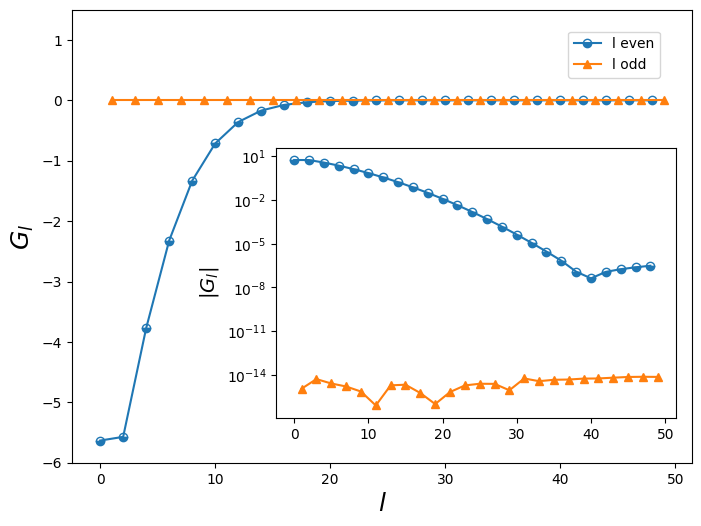

In [6]:
fig, ax1 = plt.subplots(figsize=(8, 6))
left, bottom, width, height = [0.38, 0.2, 0.5, 0.45]
ax2 = fig.add_axes([left, bottom, width, height])
d_even=[]
d_odd=[]
x_even=np.arange(0,50,2)
x_odd=np.arange(1,50,2)
for i in range(0,50,2):
    d_even.append(gl['t2g'].real.data[i,0][0])
for k in range(1,50,2):
    d_odd.append(gl['t2g'].real.data[k,0][0])
ax1.plot(x_even, d_even, marker=MarkerStyle('o', fillstyle='bottom'), label='l even')
ax1.plot(x_odd, d_odd, '-^', label='l odd')
d_even_abs= list(map(abs, d_even))
d_odd_abs= list(map(abs, d_odd))
ax2.plot(x_even, d_even_abs, marker=MarkerStyle('o', fillstyle='bottom'))
ax2.plot(x_odd, d_odd_abs, '-^')
pyplot.yscale('log')
ax1.set_ylim(-6,1.5)
ax1.legend(loc=(0.8,0.85))
ax1.set_xlabel('$l$', fontsize=18)
ax1.set_ylabel('$G_l$', fontsize=18)
ax2.set_ylabel('$|G_l|$', fontsize=14)

### 6. n_tau
Number of imaginary time points used for the Green's function.

In [ ]:
import os
if not os.path.exists('data/ntau-b10'):
    os.makedirs('data/ntau-b10')
    
# Parameters of the model
t = 1.0
beta = 10
n_loops = 1
U = 2.0
n_tau = [101, 1001, 10001]
# Construct the impurity solver

for j in range(len(n_tau)):
    # n_iw=math.floor((1/8)*n_tau[j])
    print('n_tau =', n_tau[j])
    S = Solver(beta = beta, n_iw=50, n_tau=n_tau[j], gf_struct = [('up',1), ('down',1)])
    # This is a first guess for G
    S.G_iw << SemiCircular(2*t)

    for i in range(n_loops):
        
        g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
        for name, g0 in S.G0_iw:
            g0 << inverse( iOmega_n + U/2.0 - t**2 * g )

        # Solve the impurity problem
        S.solve(h_int = U * n('up',0) * n('down',0),   # Local Hamiltonian 
            n_cycles  = 256000,                           # Number of QMC cycles
            length_cycle = 100,
            n_warmup_cycles = 4000,                      # Warmup cycles
            )
    
        # Save iteration in archive
        with HDFArchive("data/ntau-b10/half-U%i.h5"%n_tau[j]) as A:
            A['Gtau-%i'%i] = S.G_tau
            A['G-%i'%i] = S.G_iw
            A['Sigma-%i'%i] = S.Sigma_iw

Text(0.5, 1.0, '$beta=10$')

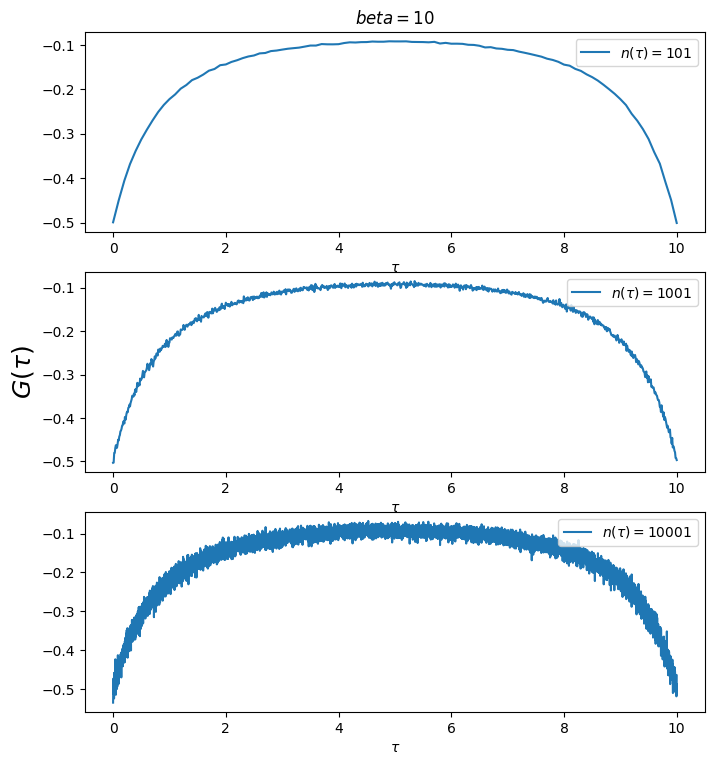

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(8, 9))
n_tau = [101, 1001, 10001]
# n_tau = [101]
for j in range(len(n_tau)):
    A1 = HDFArchive("data/ntau/half-U%i.h5"%n_tau[j], 'r')
    ax[j].oplot(A1['Gtau-0']['up'].real, '-', label=r"$n(\tau) = %i$"%n_tau[j])
    ax[j].set_ylabel('')
ax[1].set_ylabel(r'$G(\tau)$', fontsize="18")
ax[0].set_title('$beta=10$')